In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
%matplotlib inline
plt.rcParams['figure.dpi']=150
plt.rcParams['text.usetex'] = True

# ODEs model for inner medulla

### Fluxes and Flows

In [527]:
# Methods for computing water and solute fluxes
def water_fluxes(zeta_D,zeta_C,s_0,u_0,s_D,u_C):
    return zeta_D*(2*s_0+u_0-2*s_D), zeta_C*(2*s_0+u_0-u_C)

def flux_s(gamma_s,s_A,s_0):
    return gamma_s*(s_A-s_0)

def flux_u(gamma_u,u_C,u_0):
    return gamma_u*(u_C-u_0)

# Methods for computing flows and descending tubule concentration
def flows(F_D,F_C,w_D,w_C):
    return F_D - w_D, F_C - w_C, w_D + w_C

def desc_salt(c_0,F_D,zeta_D,s_0,u_0):
    a = 2*zeta_D
    b = F_D - zeta_D*(2*s_0 + u_0)
    c = -c_0*F_D
    return (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

## Forward Euler's

In [161]:
# Forward Euler's method for solving initial value problem
def fw_euler(init,params,steps,dt):
    s_D, s_A, u_C, s_0, u_0 = list(init).copy() # init must be a nested list, e.g., s_A is a list.
    gamma_s, gamma_u, zeta_D, zeta_C, c_0, F_D, F_C, v_D, v_A, v_C, v_0 = params.values() # params is a dict
    for _ in range(steps):
        w_D,w_C = water_fluxes(zeta_D,zeta_C,s_0[-1],u_0[-1],s_D[-1],u_C[-1])
        j_s = flux_s(gamma_s,s_A[-1],s_0[-1])
        j_u = flux_u(gamma_u,u_C[-1],u_0[-1])
        q_DA, q_C, q_0 = flows(F_D,F_C,w_D,w_C)
        
        s_A.append(s_A[-1]+(dt/v_A)*(q_DA*s_D[-1] - j_s - q_DA*s_A[-1]))
        u_C.append(u_C[-1]+(dt/v_C)*(c_0*F_C - j_u - q_C*u_C[-1]))
        s_0.append(s_0[-1]+(dt/v_0)*(j_s - s_0[-1]*q_0))
        u_0.append(u_0[-1]+(dt/v_0)*(j_u - u_0[-1]*q_0))
        # s_D.append(desc_salt(c_0,F_D,zeta_D,s_0[-1],u_0[-1]))
        s_D.append(s_D[-1]+(dt/v_D)*(c_0*F_D - s_D[-1]*q_DA))
    return s_D, s_A, u_C, s_0, u_0

### Plotting time

In [101]:
# A method for plotting time evolution
def plot_time(solution,dt,start=0,mode='osm'):
    s_D, s_A, u_C, s_0, u_0 = solution
    t = np.linspace(start,(len(s_D)-1)*dt,len(s_D))
    fig, ax = plt.subplots()
    fig.set_facecolor('white')
    ax.grid(True, which='both')
    ax.set_xlabel(r"$t$")
    if mode=='osm':
        osms = [2*np.array(s_D),2*np.array(s_A),u_C,2*np.array(s_0)+np.array(u_0)]
        labels = ['Desc. osm.', 'Asc. osm.', 'Col. osm.', 'Core osm.']
    elif mode=='conc':
        osms = list(solution).copy()
        labels = [r'$s_D$', r'$s_A$', r'$u_C$', r'$s_0$', r'$u_0$']
    for item in range(len(osms)):
        ax.plot(t,osms[item],label=labels[item])
    plt.legend()
    plt.show()

### Time dependent solution

In [556]:
params = {
    'gamma_s': 5, 
    'gamma_u': 5, 
    'zeta_D': 5, 
    'zeta_C': 5, 
    'c_0': 2, 
    'F_D': 5, 
    'F_C': 1, 
    'v_D': 1, 
    'v_A': 1, 
    'v_C': 1, 
    'v_0': 1
}
# init = [[desc_salt(params['c_0'],params['F_D'],params['zeta_D'],s_0=1,u_0=0)],
init = [[params['c_0']/2],    # s_D
        [params['c_0']/2],    # s_A
        [params['c_0']],  # u_C
        [params['c_0']/2],    # s_0
        [0]]                # u_0
steps = 50
dt = 0.01
sol = fw_euler(init,params,steps,dt)

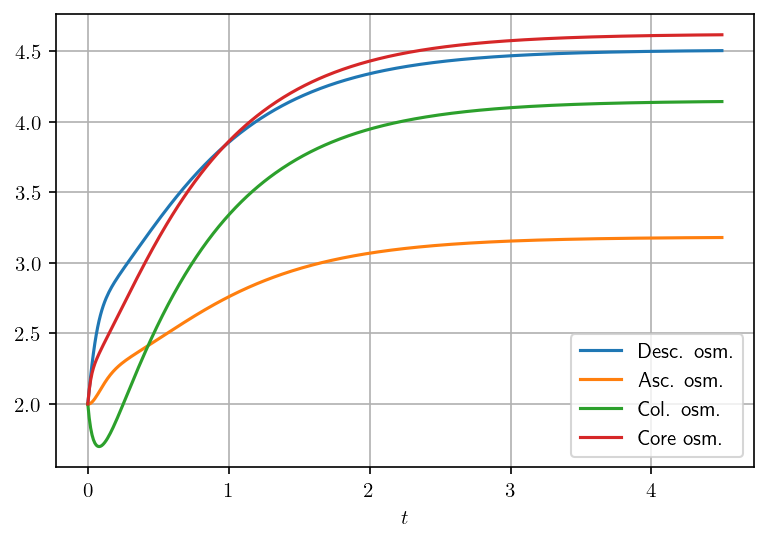

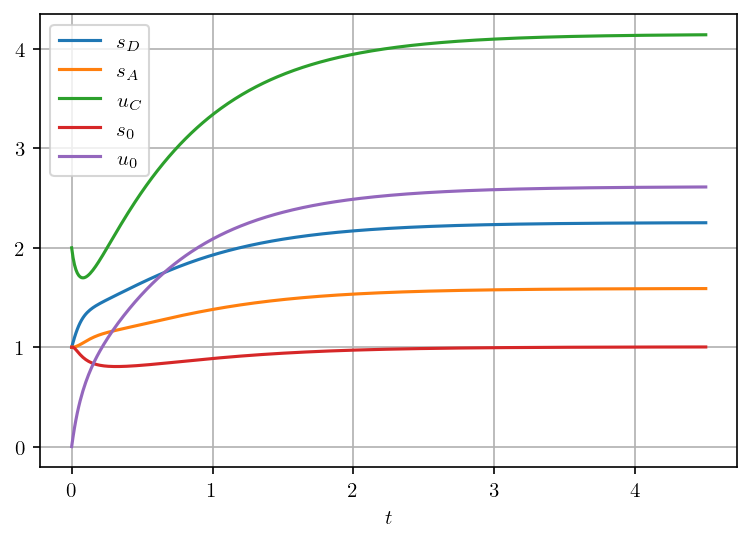

In [564]:
sol = fw_euler(sol,params,steps,dt)
plot_time(sol,dt,0)
plot_time(sol,dt,0,mode='conc')

## Steady states

Now, we use the last iteration as an initial guess when solving for a steady state solution.

In [242]:
# residue function for steady states
def ss_res(guess,params,h=0,var=[],tgnt=None,prev_ss=None):
    out = list(guess).copy()
    Params = params.copy()
    s_D, s_A, u_C, s_0, u_0 = out[:5]
    res = []
    if var:
        res = [tgnt @ (np.array(guess) - np.array(prev_ss)) - h]
        for par in var:
            Params[par] = out[-1]
    gamma_s, gamma_u, zeta_D, zeta_C, c_0, F_D, F_C, v_D, v_A, v_C, v_0 = Params.values() # params is a dict

    w_D,w_C = water_fluxes(zeta_D,zeta_C,s_0,u_0,s_D,u_C)
    j_s = flux_s(gamma_s,s_A,s_0)
    j_u = flux_u(gamma_u,u_C,u_0)
    q_DA, q_C, q_0 = flows(F_D,F_C,w_D,w_C)

    res = [
        c_0*F_D - s_D*q_DA,
        q_DA*s_D - j_s - q_DA*s_A,
        c_0*F_C - j_u - q_C*u_C,
        c_0*F_C - j_u - q_C*u_C,
        j_u - u_0*q_0
    ] + res
    
    return res

In [567]:
# Params = params.copy()
# Params['gamma_s'] += 0.1
# Params['gamma_u'] += 0.1
# ss = fsolve(ss_res,list(ss),args=(params))
# ss, params['gamma_s']

(array([2.25762254, 1.59421952, 4.15526111, 1.00651895, 2.61631949]), 5)

In [566]:
ss = fsolve(ss_res,list(np.array(sol).T[-1]),args=(params))

### Numerical continuation with varying solute permeabilities

In [244]:
def num_cont(startx2,params,h=0.01,var=['gamma_s','gamma_u'],steps=20):
    soln_mnfld = list(startx2).copy()
    for _ in range(steps):
        tgnt = np.array(soln_mnfld[-1]) - np.array(soln_mnfld[-2])
        tgnt = tgnt/np.sqrt(tgnt @ tgnt)
        soln_mnfld.append(list(fsolve(ss_res,soln_mnfld[-1],args=(params,h,var,tgnt,soln_mnfld[-1]))))
    return soln_mnfld

In [571]:
# params['gamma_s'] -= 0.5
# params['gamma_u'] -= 0.5
sss = [list(ss) + [params['gamma_s']]] 
params['gamma_s'] += 0.1
params['gamma_u'] += 0.1
sss.append(list(fsolve(ss_res,list(ss),args=(params))) + [params['gamma_s']])

In [569]:
sss = num_cont(sss,params,steps=2000)

#### Plotting the solution manifold

In [259]:
def plot_solnmnfld(ss_par,par_label=r'$\gamma_s=\gamma_u$',mode='osm'):
    s_D, s_A, u_C, s_0, u_0, par = list(np.array(ss_par).T)
    fig, ax = plt.subplots()
    ax.grid(True, which='both')
    ax.set_xlabel(par_label)
    if mode=='osm':
        ys = [2*np.array(s_D),2*np.array(s_A),u_C,2*np.array(s_0)+np.array(u_0)]
        labels = ['Desc. osm.', 'Asc. osm.', 'Col. osm.', 'Core osm.']
        ax.set_ylabel(r"osmolarity")
    elif mode=='conc':
        ys = [s_D,s_A,u_C,s_0,u_0]
        labels = [r'$s_D$', r'$s_A$', r'$u_C$', r'$s_0$', r'$u_0$']
        ax.set_ylabel(r"concentration")
    for k in range(len(ys)):
        ax.plot(par, ys[k], label=labels[k])
    ax.legend()
    plt.show

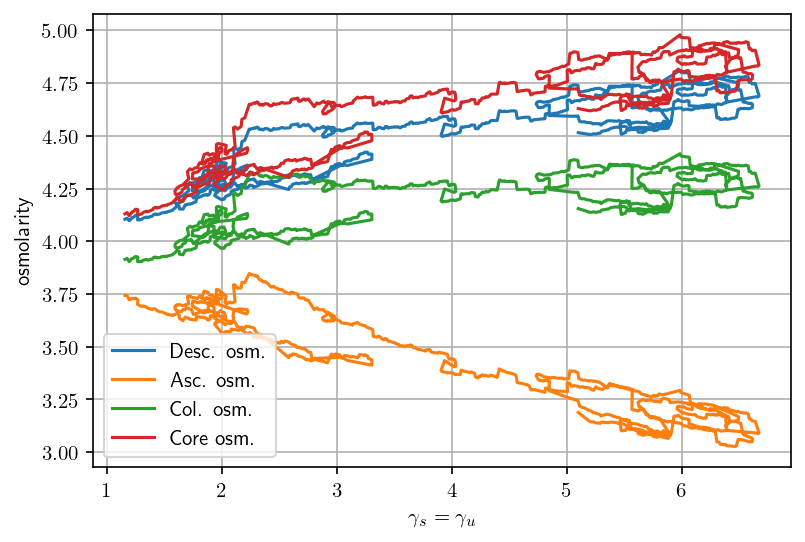

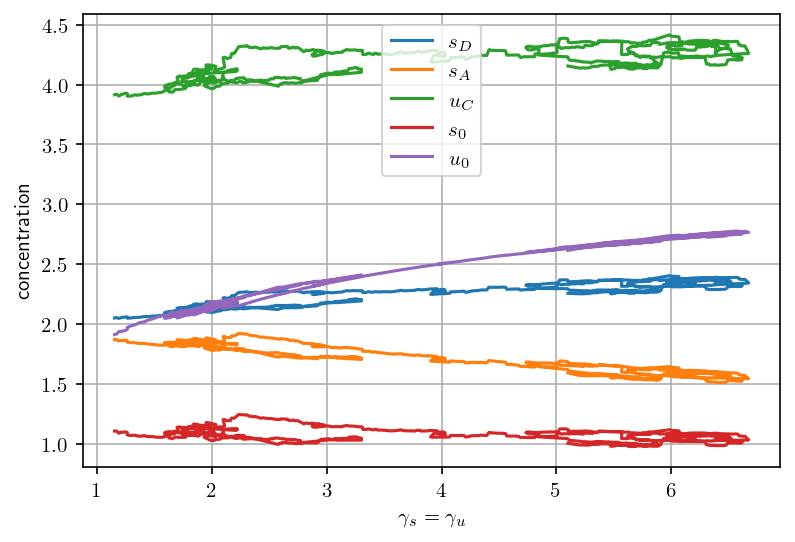

In [578]:
sss = num_cont(sss,params,steps=200)
plot_solnmnfld(sss)
plot_solnmnfld(sss,mode='conc')

## Scale $\gamma$ and $\zeta$ simultaneously
Say $\gamma_s=\gamma_u=\zeta_D=\zeta_C$?

In [579]:
params['gamma_s'] -= 0.1
params['gamma_u'] -= 0.1
sss = [list(ss) + [params['gamma_s']]] 
params['gamma_s'] += 0.1
params['gamma_u'] += 0.1
params['zeta_D'] += 0.1
params['zeta_C'] += 0.1
sss.append(list(fsolve(ss_res,list(ss),args=(params))) + [params['gamma_s']])
sss

[[2.257622536722448,
  1.5942195156078731,
  4.155261108186207,
  1.0065189497904279,
  2.6163194900408167,
  5.1],
 [2.2071084482031234,
  1.527482761953604,
  4.050738123614125,
  0.935317716955188,
  2.6355785269849066,
  5.199999999999999]]

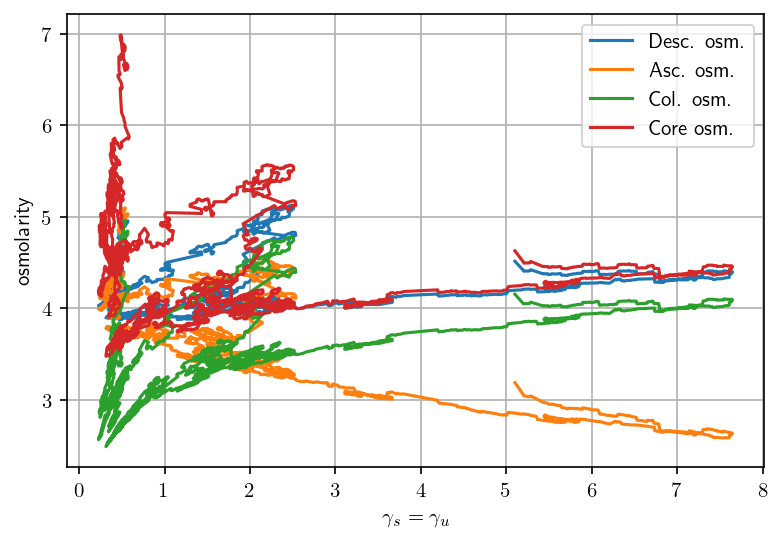

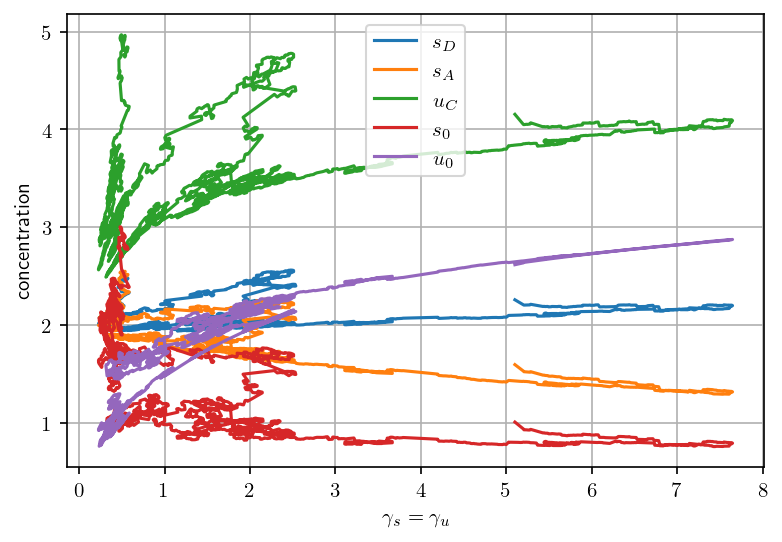

In [598]:
sss = num_cont(sss,params,steps=200,var=['gamma_s','gamma_u','zeta_D','zeta_C'])
plot_solnmnfld(sss)
plot_solnmnfld(sss,mode='conc')